# CS172 Assignment 1: CAPTCHAs
Shanghaitech University 2025 Fall Computer Vision I

Welcome to the first assignment of CS172. In this homework, we aim to build and train a neural network model to recognize CAPTCHAs consisting only of Arabic numerals (0-9). The primary focus is on generating synthetic verification code data, preprocessing it, and building a convolutional neural network (CNN) for character recognition.

## Part 0: Setup
Before running the notebook, ensure that your environment is properly set up. Install the necessary dependencies, which include `torch`, `torchvision`, `PIL`, and `matplotlib`. These can be installed via conda and pip using the command:
```
conda create -n 172a1 python=3.8
conda activate 172a1
pip install -r requirements.txt
```
Then you can run the following code to load the necessary packages.

In [1]:
import torch, os
from cs172 import utils
from cs172 import generate
from cs172.datasets import ImageDataset
from cs172.networks import get_model
# from cs172.pipeline import train, test

utils.set_seed(172)

## Part 1: Data Generation
Implement the `generate_verification` function in `cs172/generate.py`, where we generate synthetic images of verification codes. Each image contains a series of Arabic numerals. 
You can modify parameters such as colors, noise level and noise type.

After implementing this function, you can display some data by running the following code.

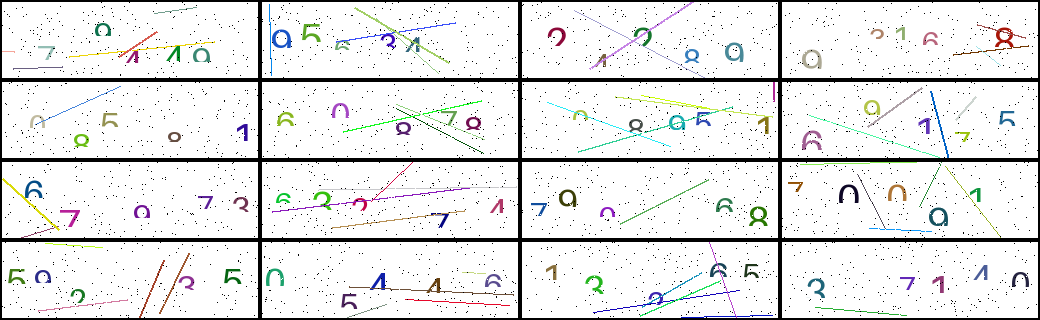

In [2]:
need_rotate = True # Do not modify this line
images = [generate.generate_verification(need_rotate=need_rotate)[0] for _ in range(16)]
display(utils.merge_images(images))

To generate the training dataset, run the following code:

In [ ]:
need_rotate = True # if you do not want to rotate the image for training, feel free to set it to False
image_size = (260, 80)
data_num = 100000 # total data num
save_folder = 'data' # set data folder

# You can comment out the line to avoid duplicate data generation
generate.save_certification_data(image_size, data_num, save_folder, need_rotate)

  0%|          | 0/100000 [00:00<?, ?it/s]

Discussion:
- What are some real-world challenges you might encounter when working with CAPTCHA images compared to our synthetic ones (e.g., distortions, noise)?
- Would using different fonts or noise levels impact the model's learning ability? How would you test this?

## Part 2: Data Preprossing
Implement `__len__` and `__getitem__` functions in `cs172/datasets.py` for a customized `Dataset` class.

Then you can run the following code to preprocess the generated images to fit the neural network's input and batch the data using Pytorch's `DataLoader`. 

You can change the `transform` variable which may include steps such as resizing the images, normalizing pixel values.

In [ ]:
# You can try different transform for data augmentation
# torchvision.transforms may be useful
transform = None

save_folder = 'data'
dataset = ImageDataset(imgdir=save_folder, transform=transform)

print(len(dataset))

ratio = 0.8
train_size = int(ratio * len(dataset))
test_size = len(dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# you can modify batch_size if 'CUDA OUT OF MEMORY'
batch_size = 128
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size,
    shuffle=True, num_workers=0)
valid_dataloader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=batch_size,
    shuffle=False, num_workers=0)

img, label = next(iter(train_dataloader))
print(img[0].min(), img[0].max())
print(label[0])
img.shape, label.shape

Discussion:
- How important is data normalization in neural networks? What could happen if you skip this step?
- What effect does batch size have on model performance and training speed? How would you balance memory usage with batch size selection?

## Part 3: Model Architecture
Implement ResNet18 in `networks.py`, which contains `SimpleResBlock` and `ResNet18` class. 

For `SimpleResBlock`, you can follow this structure to implement each layer(weight layer, activation funcyion, residual...)

The residual block has two $3 \times 3$ convolutional layers with the same number of output channels. Each convolutional layer is followed by a batch normalization layer and a ReLU activation function. 
Then, we skip these two convolution operations and add the input directly before the final ReLU activation function. 
This kind of design requires that the output of the two convolutional layers has to be of the same shape as the input, so that they can be added together. 
If we want to change the number of channels, we need to introduce an additional $1 \times 1$ convolutional layer to transform the input into the desired shape for the addition operation. 

![ResBlock](assets/resnet-block.svg "picture is from https://d2l.ai/")

For `ResNet18`, you can follow this structure:

The first two layers of ResNet are the same as those of the GoogLeNet we described before: the $7 \times 7$ convolutional layer with 64 output channels and a stride of 2 is followed by the $3 \times 3$ max-pooling layer with a stride of 2. The difference is the batch normalization layer added after each convolutional layer in ResNet.

ResNet uses four modules made up of residual blocks, each of which uses several residual blocks with the same number of output channels. The number of channels in the first module is the same as the number of input channels. Since a max-pooling layer with a stride of 2 has already been used, it is not necessary to reduce the height and width. In the first residual block for each of the subsequent modules, the number of channels is doubled compared with that of the previous module, and the height and width are halved.

Then, we add all the modules to ResNet. Here, two residual blocks are used for each module. Lastly, we add a global average pooling layer, followed by the fully connected layer output.

There are four convolutional layers in each module (excluding the $1 \times 1$ convolutional layer). Together with the first $7 \times 7$ convolutional layer and the final fully connected layer, there are 18 layers in total. Therefore, this model is commonly known as ResNet-18. 

![CAPTCHAs](assets/resnet18-90.svg "picture is from https://d2l.ai/, which is a very useful deep learning book") 

Pictures and descriptions come from [Dive into Deep Learning](https://d2l.ai/), which is a very helpful deep learning book.

After implementing the networks architecture, you can run the following code to train the model.

In [ ]:
# Change model_name to compare with the ResNet implementation in torchvision
model_name = "myresnet18"
assert model_name in ("myresnet18", "resnet18", "resnet34")
model = get_model(model_name)
model

Discussion:
- What modifications could you make to the current architecture if the model struggles with overfitting or underfitting?
- Would you consider using a different type of model (like MLP) for this task? Why or why not?

## Part 4: Training
In`pipeline.py`, implement a training loop for the model. You will fine-tune hyperparameters like learning rate, batch size, and optimizer, while monitoring the model's performance with loss and accuracy metrics.

In [ ]:
device = "cuda" if torch.cuda.is_available() else 'cpu'

if os.path.exists("model_weights.pth"):
    model_weights = torch.load("model_weights.pth")
    model.load_state_dict(model_weights)
else:
    # you can try different hyperparameters by passing args `lr`, `weight_decay`, `num_epoch`
    train(model, device, train_dataloader)

# save model weights, thus you can try different hyperparameters without retraining
torch.save(model.state_dict(), "model_weights.pth")

Discussion:
- How would you approach adjusting the learning rate if the model's accuracy plateaus early? Could a learning rate schedule improve training?
- Would regularization methods (such as dropout or L2 regularization) be beneficial for this task? When would you apply them?
- How would you know when to stop training the model? Should early stopping be implemented, and if so, how would you determine when?

## Part 5: Evaluation
After training, evaluate the model's performance on the validation and test datasets using metrics such as digit accuracy and image accuracy. Visualize predictions and errors to understand the model’s strengths and weaknesses.
You could add more experiments and disscussion (like loss decay, metric table, hyperparameter ablation study) in this section.

In [ ]:
# test on your valid data
device = "cuda" if torch.cuda.is_available() else 'cpu'
metrics = test(model, device, valid_dataloader)
for key, value in metrics.items():
    print(f"{key}:", value.item())

Experiment with various hyperparameters — including learning rates, batch sizes, network architecture (e.g., number of layers, filter sizes, and activations), loss decay, and metric settings — on your own generated validation set. Analyze the results and report the best-performing configuration here:


In [ ]:
# test on sample test data
# There are 5 test sets in 'samples'. To receive full points for each test set,
# your model must achieve a digit accuracy ≥ 0.95 and an image accuracy ≥ 0.75.
folders = sorted(os.listdir('samples'))
for folder in folders:
    if folder == "test_alphabet":
        continue 

    test_dataset = ImageDataset(os.path.join('samples', folder), transform=transform)
    test_dataloader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size,
        shuffle=False, num_workers=0,
    )
    metrics = test(model, device, test_dataloader)
    for key, value in metrics.items():
        print(f"{key} for {folder}:", value.item())
    
    model.eval()
    images, imgs, labels = zip(*[test_dataset.get_samples(idx) for idx in range(4)])
    labels = [label.reshape(5, 10).argmax(axis=-1).tolist() for label in labels]
    with torch.no_grad():
        preds = [model(torch.tensor(img).unsqueeze(0).to(device))[0].reshape(5, 10).argmax(axis=-1).cpu().numpy().tolist() for img in imgs]
    display(utils.merge_images(images, grid_size=(4, 1)))
    print(labels)
    print(preds)

Discussion:
- How reliable are accuracy metrics for evaluating the model? Would other metrics offer additional insights?
- What kinds of errors are the most common—misrecognition of certain digits, complete failures? How could you address these types of errors?

## Part 6: Discussion
There are 11 discussion questions above. You need to answer all of them, each worth 1 point.

## Bonus: Alphabet CAPTCHA Recognition

In this part, you are encouraged to extend your model to recognize alphabetic CAPTCHAs (A–Z, a–z).
We have provided some pre-generated alphabet CAPTCHA images for test.

To complete this part, you should:
- Show several examples of the training data you generated or used.
- Report the modifications you made compared to the numeric CAPTCHA setting (e.g., data generation, model architecture, or training strategy).
- Report your training accuracy.
- Report your accuracy on the provided test set.

You can add new cells below to organize your experiments, show results, and summarize your findings.
Feel free to explore different ideas — creativity is encouraged!

In [ ]:
import os 
transform = None
batch_size = 128
folder = 'test_alphabet'

test_dataset = ImageDataset(os.path.join('samples', folder), transform=transform)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size,
    shuffle=False, num_workers=0,
)